In [1]:
import os
import torch
from torch import Tensor
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch import nn
from torch.optim import Adam
from pathlib import Path
from tqdm.notebook import tqdm
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from scipy.optimize import curve_fit 
import math

# imports of our code 
from load_models import *
import LocalLearning_copy as LocalLearning

In [2]:
torch.manual_seed(7)

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
# Hyper parameters:
BATCH_SIZE = 1000
NUMBER_OF_EPOCHS = 1000
LEARNING_RATE = 1e-4

# loss function
ce_loss = torch.nn.CrossEntropyLoss()

In [4]:
cifar10Train= LocalLearning.LpUnitCIFAR10(
            root="../data/CIFAR10",
            train=True,
            transform=ToTensor(),
            p=3.0,
        )

cifar10Test= LocalLearning.LpUnitCIFAR10(
            root="../data/CIFAR10",
            train=False,
            transform=ToTensor(),
            p=3.0,
        )

TestLoader = LocalLearning.DeviceDataLoader(
            cifar10Test,
            device=device,
            batch_size=BATCH_SIZE,
            num_workers=4,
            shuffle=True,
        )

TrainLoader = LocalLearning.DeviceDataLoader(
            cifar10Train,
            device=device,
            batch_size=BATCH_SIZE,
            num_workers=4,
            shuffle=True,
        )

Files already downloaded and verified
Files already downloaded and verified


In [5]:
label_names = ["airplane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [6]:
def data_critirium(
    dataloader,
    model, 
    crit,
    thres = None
    ):
    
    # Returns the data and the corresponding labels that meets the critirium given (crit)
    
    freq_correct = 0
    model.eval()
    total = 0
    
    data = torch.zeros((0,32,32,3)).to(device)
    lab_data = torch.zeros((0)).to(device)
    
    for batch_no, (features, labels) in enumerate(dataloader):
        preds = model(features)
        pred = torch.argmax(preds, dim=-1)
        
        if crit == "correct":
            filtr_idx = (torch.abs(pred - labels) == 0)
            new_features = features[filtr_idx]
            data = torch.cat((data, new_features),dim=0)
            new_labels = labels[filtr_idx]
            lab_data = torch.cat((lab_data, new_labels),dim=0)
        
        elif crit == "correct_thres":
            softmax_correct = (preds[torch.arange(1000),pred])
            thres_idx = (softmax_correct >= thres)
            correct_idx = (torch.abs(pred - labels) == 0)
            filtr_idx = thres_idx & correct_idx 
            new_features = features[filtr_idx]
            data = torch.cat((data, new_features),dim=0)
            new_labels = labels[filtr_idx]
            lab_data = torch.cat((lab_data, new_labels),dim=0)
            
        elif crit == "thres":
            softmax_correct = (preds[torch.arange(1000),pred])
            filtr_idx = (softmax_correct >= thres)
            new_features = features[filtr_idx]
            data = torch.cat((data, new_features),dim=0)
            new_labels = labels[filtr_idx]
            lab_data = torch.cat((lab_data, new_labels),dim=0)
            
        else: 
            raise ValueError("Not a valid criterium")
    
    return data, lab_data

In [7]:
max_num_steps = 1200
step_size = 0.001
eps_start = 0

eps_list = [eps_start + n * step_size for n in range(max_num_steps + 1)]

In [8]:
def crit_eps(criterium, model, attack, print_accuracy=False):
    
    features, labels = data_critirium(TestLoader, model, criterium)
    labels = labels.type(torch.LongTensor).to(device)
    features.requires_grad = True
    
    siz = len(labels)

    crit_eps_per_image = torch.ones(siz).to(device).fill_(math.nan)   
    crit_dist_per_image = torch.ones(siz).to(device).fill_(math.nan)

    freq_correct = 0
    total = 0 

    loss_fn = ce_loss 
    optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

    correct = []

    perturbed_image = features 
    b_norm = 0.05
    
    noise = torch.randn(features.shape).to(device)
    
    images = []
    accuracy_dict = {}

    with tqdm(total=len(eps_list)) as pbar:
        for i, eps in enumerate(eps_list):
        
            preds = model(features)
            loss = loss_fn(preds, labels)
            optimizer.zero_grad()
            loss.backward()

            with torch.no_grad():

                if attack == "WN":
                    adv_image = features + eps*noise
                    perturbed_image = torch.clamp(adv_image, min = 0, max = 1)

                elif attack == "PGD":

                    adv_image = perturbed_image + step_size*features.grad.data.sign()
                    clamp = torch.clamp(adv_image - features, min = -b_norm, max = b_norm)
                    perturbed_image = torch.clamp(features + clamp, min = 0, max = 1)

                elif attack == "FGSM":

                    perturbed_image = features + eps*features.grad.data.sign()
                    perturbed_image = torch.clamp(perturbed_image, 0, 1)

                preds_perturbed = torch.argmax(model(perturbed_image), dim=-1)
                alike = (preds_perturbed == labels)
                freq_correct += (torch.abs(preds_perturbed - labels) == 0).sum()
                total += len(labels)
                
                accuracy = (freq_correct/total).item()
                correct.append(accuracy)
                accuracy_dict[eps] = accuracy

                mask = (alike == False) & (crit_eps_per_image.isnan())

                x = features.view(features.size(0),-1)
                y = perturbed_image.view(perturbed_image.size(0),-1)

                dist = torch.norm(x - y, dim=1).detach()

                crit_dist_per_image[mask] = dist[mask]

                perturbation = torch.abs(features - perturbed_image).detach()
                avg_perturbation = torch.sum(perturbation.view(perturbation.size(0), -1), dim=1) / (perturbation.size(1) * perturbation.size(2) * perturbation.size(3))
                crit_eps_per_image[mask] = avg_perturbation[mask]
                
                pbar.update(1)
                
                if (i in [0,10,20,30,100]) and (attack == "WN"):
                    info = [perturbed_image, labels, preds_perturbed, features, eps]
                    images.append(info)
                    
                if (i in [0,1,2,3,10]) and (attack == "PGD" or attack == "FGSM"):
                    info = [perturbed_image, labels, preds_perturbed, features, eps]
                    images.append(info)
    
    if print_accuracy == True:
        print(f"{correct[-1]*100:.2f}% is still correctly classified")
        print(f"{100*(torch.sum(crit_eps_per_image.isnan()).item())/siz}% have been correctly classified at every step")
        
    crit_eps_per_image = np.array(crit_eps_per_image.cpu())
    crit_dist_per_image = np.array(crit_dist_per_image.cpu())
    correct = np.array(correct)
        
    return crit_eps_per_image, crit_dist_per_image, correct, images, accuracy_dict


In [9]:
def boxplot(ll_crit_eps, bp_crit_eps, attack, typ):
    
    # Remove NaN values from the input data
    ll_crit_eps = ll_crit_eps[~np.isnan(ll_crit_eps)]
    bp_crit_eps = bp_crit_eps[~np.isnan(bp_crit_eps)]
    
    fig, ax = plt.subplots()
    ax.boxplot((ll_crit_eps, bp_crit_eps), showfliers=False)
    ax.set_xticklabels(['LL', 'BP'])
    if typ == "eps":
        ax.set_ylabel('Critical epsilon')
    elif typ == "dist":
        ax.set_ylabel('Critical distance')
        
    ax.set_title(f'Konstantin model {attack} attack')
    
    median_ll = np.nanmedian(ll_crit_eps)
    median_bp = np.nanmedian(bp_crit_eps)
    ax.text(0.95, 0.95, f"Median LL: {median_ll:.5f}\nMedian BP: {median_bp:.5f}", 
            verticalalignment='top', horizontalalignment='right',
            transform=ax.transAxes, fontsize=12)

    plt.show()


In [10]:
def plot_accuracy(ll, bp):
    plt.plot(ll*100,label="ll")
    plt.plot(bp*100,label="bp")
    plt.ylabel("Accuracy [%]")
    plt.xlabel("Iterations")
    plt.legend()
    plt.show()

In [11]:
def plot_accuracy_vs_epsilon(accuracy_dict, modeltype):
    epsilons = sorted(accuracy_dict.keys())
    accuracies = [accuracy_dict[eps] for eps in epsilons]
    title="Accuracy vs Epsilon " + modeltype
    

    plt.figure()
    plt.plot(epsilons, accuracies, marker='o')
    plt.xlabel('Epsilon')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.show()

In [12]:
idx = 42

def MinMaxNorm(x: np.array) -> np.array:
        mi = np.amin(x)
        ma = np.amax(x)
        return (x - mi) / (ma - mi)

def show_image(features):

    f_np = features.detach().cpu().numpy()
    HM = np.zeros((32, 32, 3))
    HM = np.transpose(f_np[idx], (0, 1, 2))
    HM = MinMaxNorm(HM)
    nc = np.max(np.absolute(HM))
    plt.axis("off")
    plt.imshow(HM, vmin=-nc, vmax=+nc)
    
def plot_images(images):
    
    N = len(images)
    
    ilist = [i for i in range(2,N+2)]
    plt.figure(figsize=(15,5))
    
    plt.subplot(1,N+1,1)
    show_image(images[0][3])
    plt.title(f"Actual = {label_names[images[0][1][idx]]}")
    
    plt.axvline(x=33, color='k', linestyle='--')
        
    for image,i in zip(images[1:],ilist):
        
        plt.subplot(1,N+1,i)
        show_image(image[0])
        
        predicted_idx = int(image[2][idx])
        
        plt.title(f"{label_names[predicted_idx]}, ε = {image[-1]}")
        
    #plt.suptitle("Actual, predicted")
    plt.show()

In [13]:
# functions for downloading models in load_models.py 
bp_modelK = load_Konstantin_model("bp_KHModel_kh_layer_cifar10.pty","bp")
ll_modelK = load_Konstantin_model("ll_KHModel_kh_layer_cifar10.pty","ll")

In [14]:
pa = False # print accuracy
si = True # show images

In [15]:
criteps_bp_wn, critdist_bp_wn, correct_bp_wn, images_bp_wn, accuracy_dict_bp_wn = crit_eps("correct", bp_modelK, "WN", print_accuracy=pa)
criteps_ll_wn, critdist_ll_wn, correct_ll_wn, images_ll_wn, accuracy_dict_ll_wn = crit_eps("correct", ll_modelK, "WN", print_accuracy=pa)

  0%|          | 0/1201 [00:00<?, ?it/s]

  0%|          | 0/1201 [00:00<?, ?it/s]

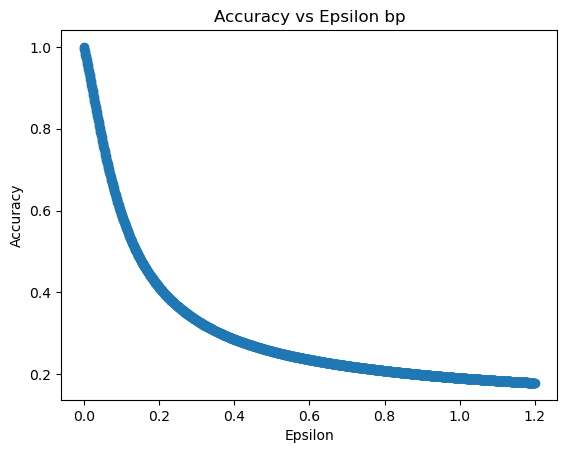

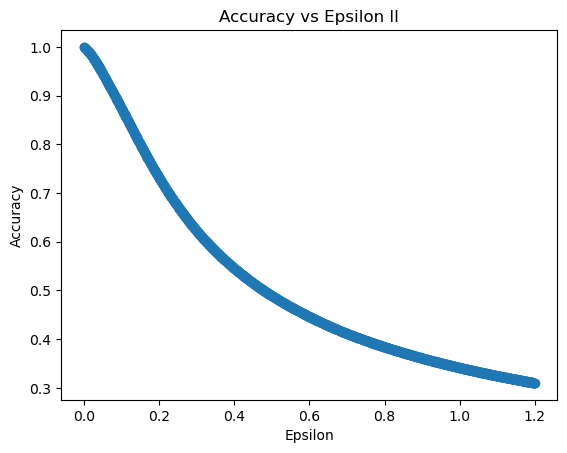

In [16]:
plot_accuracy_vs_epsilon(accuracy_dict_bp_wn, "bp")
plot_accuracy_vs_epsilon(accuracy_dict_ll_wn, "ll")

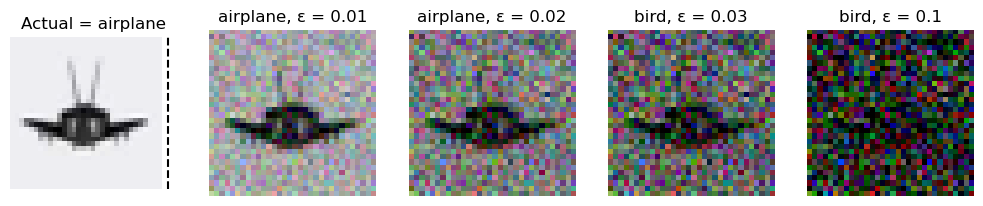

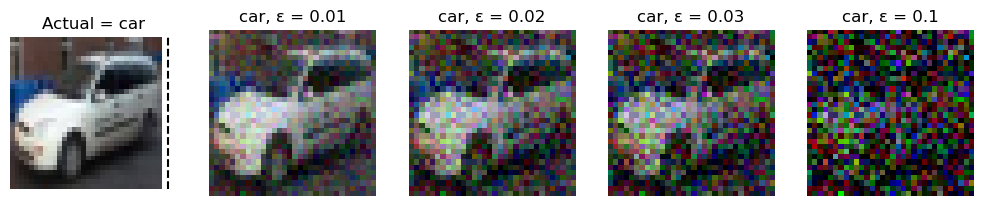

In [17]:
plot_images(images_bp_wn)
plot_images(images_ll_wn)

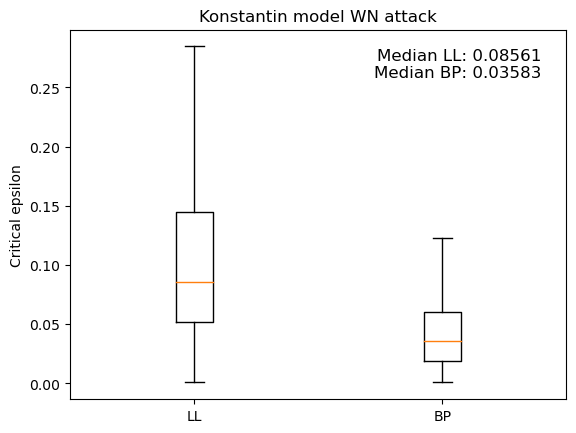

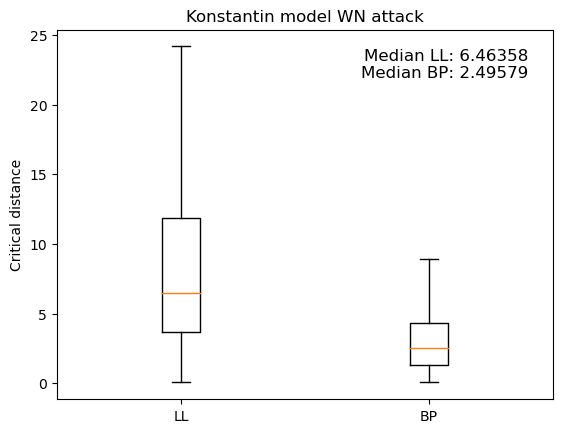

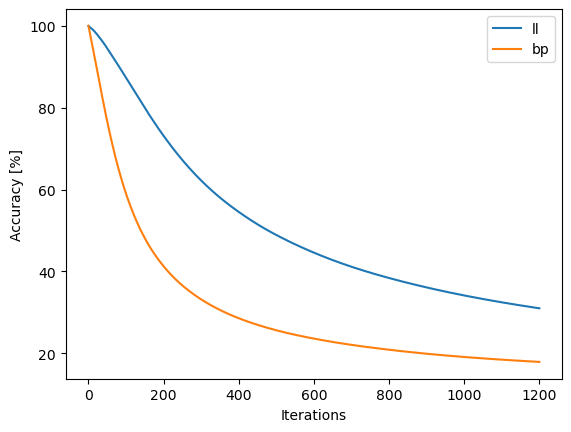

In [18]:
boxplot(criteps_ll_wn, criteps_bp_wn, "WN", "eps")
boxplot(critdist_ll_wn, critdist_bp_wn, "WN", "dist")
plot_accuracy(correct_ll_wn,correct_bp_wn)

In [19]:
criteps_bp_pgd, critdist_bp_pgd, correct_bp_pgd, images_bp_pgd, accuracy_dict_bp_pgd = crit_eps("correct", bp_modelK, "PGD", print_accuracy=pa)
criteps_ll_pgd, critdist_ll_pgd, correct_ll_pgd, images_ll_pgd, accuracy_dict_ll_pgd = crit_eps("correct", ll_modelK, "PGD", print_accuracy=pa)

  0%|          | 0/1201 [00:00<?, ?it/s]

  0%|          | 0/1201 [00:00<?, ?it/s]

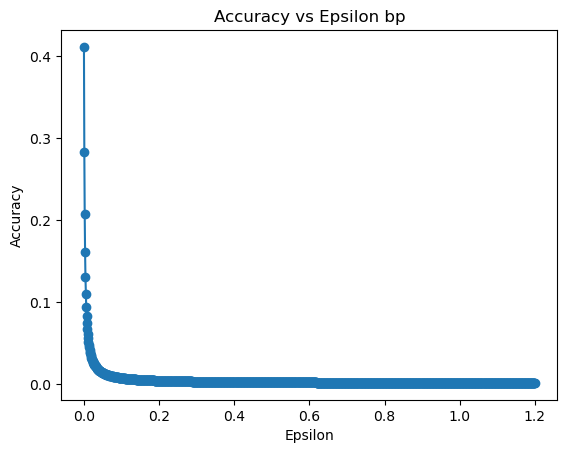

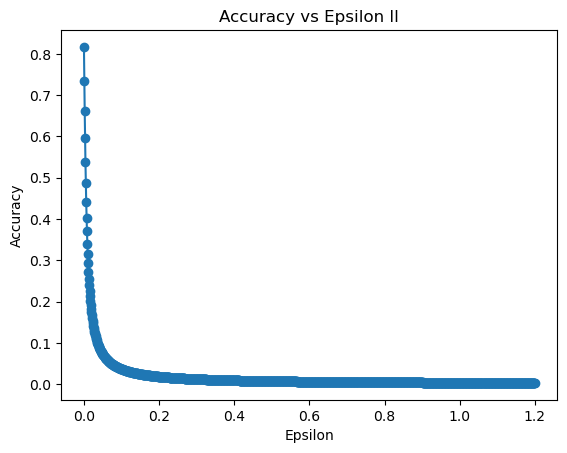

In [20]:
plot_accuracy_vs_epsilon(accuracy_dict_bp_pgd, "bp")
plot_accuracy_vs_epsilon(accuracy_dict_ll_pgd, "ll")

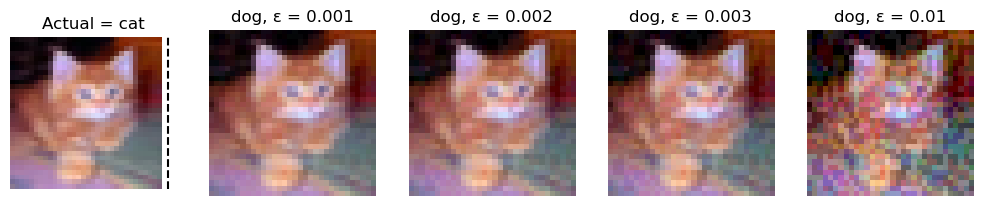

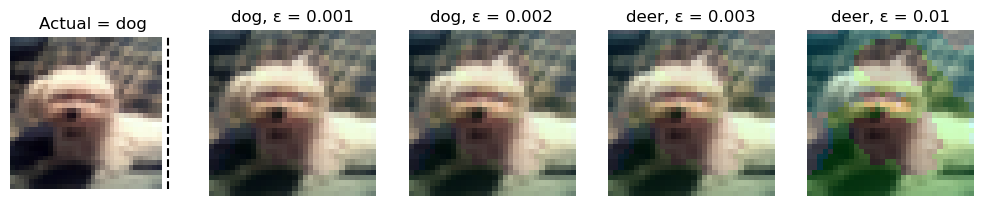

In [21]:
plot_images(images_bp_pgd)
plot_images(images_ll_pgd)

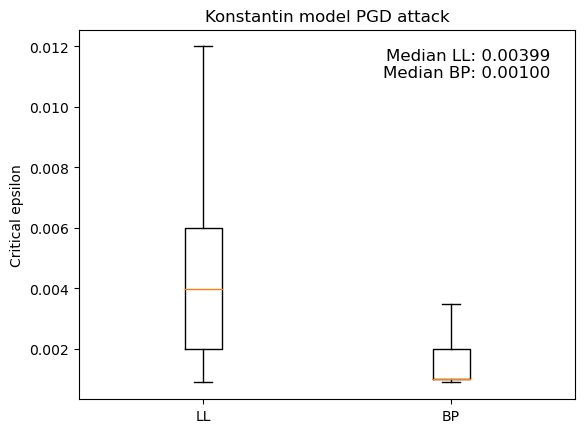

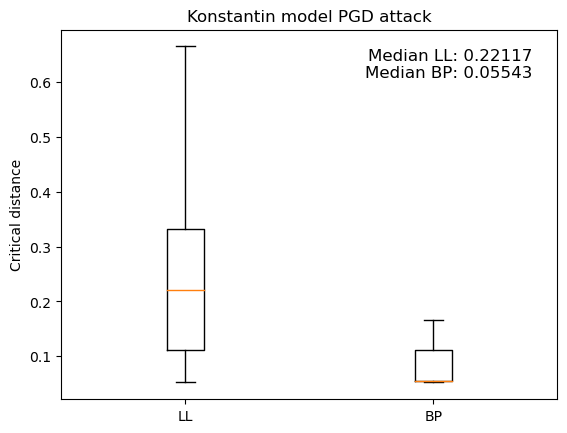

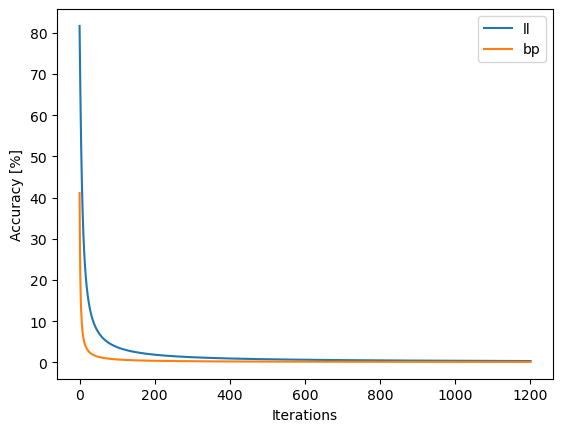

In [22]:
boxplot(criteps_ll_pgd, criteps_bp_pgd, "PGD", "eps")
boxplot(critdist_ll_pgd, critdist_bp_pgd, "PGD", "dist")
plot_accuracy(correct_ll_pgd,correct_bp_pgd)

In [23]:
criteps_bp_fgsm, critdist_bp_fgsm, correct_bp_fgsm, images_bp_fgsm, accuracy_dict_bp_fgsm = crit_eps("correct", bp_modelK, "FGSM", print_accuracy=pa)
criteps_ll_fgsm, critdist_ll_fgsm, correct_ll_fgsm, images_ll_fgsm, accuracy_dict_ll_fgsm = crit_eps("correct", ll_modelK, "FGSM", print_accuracy=pa)

  0%|          | 0/1201 [00:00<?, ?it/s]

  0%|          | 0/1201 [00:00<?, ?it/s]

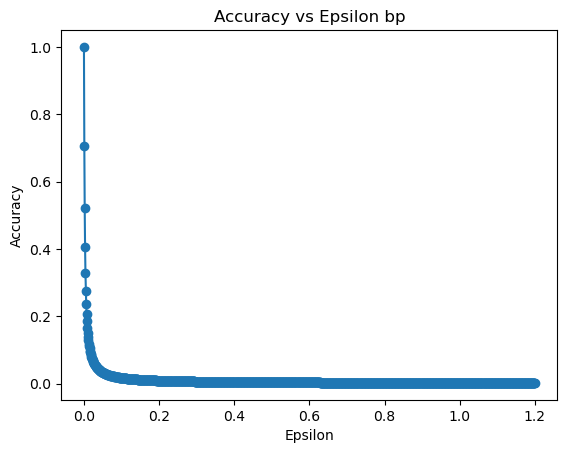

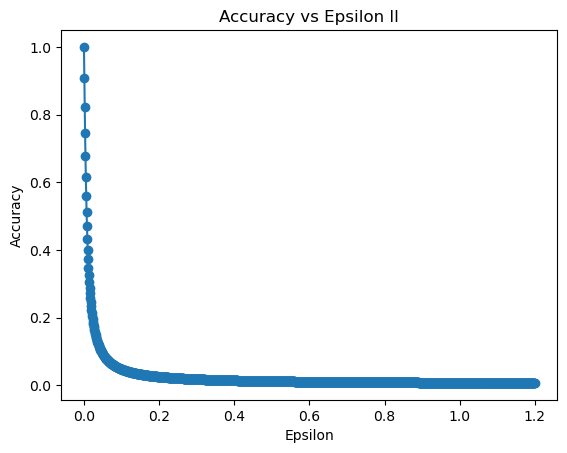

In [24]:
plot_accuracy_vs_epsilon(accuracy_dict_bp_fgsm, "bp")
plot_accuracy_vs_epsilon(accuracy_dict_ll_fgsm, "ll")

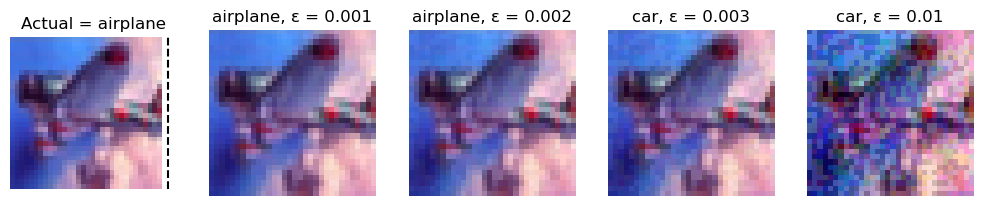

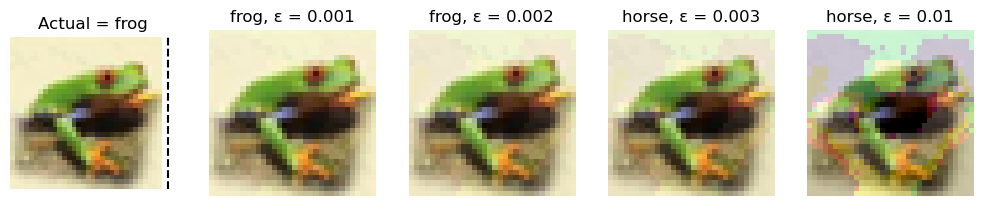

In [25]:
plot_images(images_bp_fgsm)
plot_images(images_ll_fgsm)

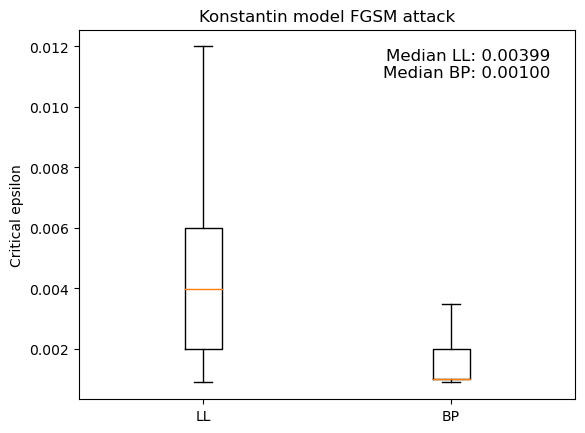

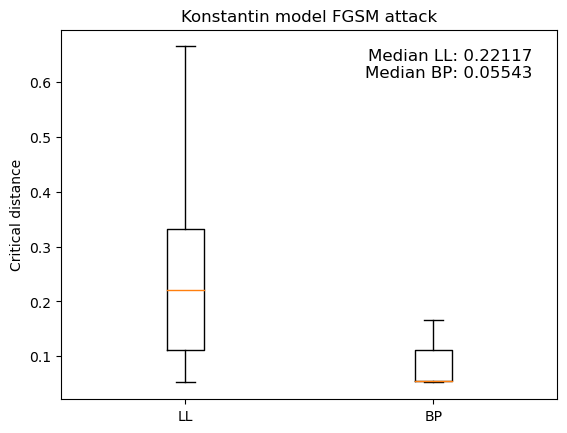

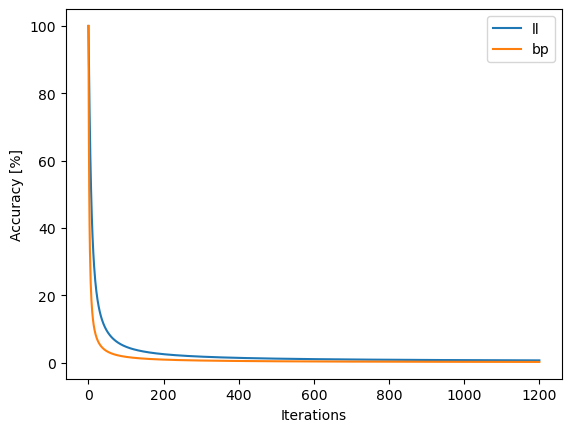

In [26]:
boxplot(criteps_ll_fgsm, criteps_bp_fgsm, "FGSM", "eps")
boxplot(critdist_ll_fgsm, critdist_bp_fgsm, "FGSM", "dist")
plot_accuracy(correct_ll_fgsm,correct_bp_fgsm)